In [1]:
import numpy.random
import matplotlib.pyplot as plt
from kendall import KendallSimulator, KendallServer, KendallEvent
from kendall.queues import RandomServerQueue
from kendall.spawners import ExponentialSpawner


def average(list):
    return sum(list) / float(len(list))


class TelephoneLine(KendallServer):
    def __init__(self, queue, id):
        self.queue = queue
        self.id = id
        self.reset()

    def assign(self, event, time):
        self.event = event
        self.start_time = time

    def complete(self, event, time):
        self.event = None
        self.total_time += time - self.start_time
        self.start_time = None

    def reset(self):
        self.event = None
        self.start_time = None
        self.total_time = 0.00


class CallEvent(KendallEvent):
    average_call_duration = 300.0
    count = 0
    dropped = 0
    last_spawn_time = 0.0
    spawn_delays = []
    call_durations = []
    all_calls = []

    def __init__(self, *args, **kwargs):
        super(CallEvent, self).__init__(*args, **kwargs)
        CallEvent.count += 1
        CallEvent.all_calls.append(self)
        self.count = CallEvent.count
        self._processing_time = numpy.random.exponential(CallEvent.average_call_duration)

    def on_enqueue(self, queue, time):
        self.enter_time = time
        CallEvent.spawn_delays.append(time - CallEvent.last_spawn_time)
        CallEvent.call_durations.append(self._processing_time)
        CallEvent.last_spawn_time = time
        # print "Ship {} entered harbor at {}! Current queue: {}".format(self.count, time, len(queue.queue))

    def on_drop(self, queue, time):
        CallEvent.dropped += 1
        self.status = "dropped"
        # print "Call {} was dropped at {}!".format(self.count, time)

    def on_process(self, server, time):
        # print "Call {} was started at {}!".format(self.count, time)
        self.status = "processed"
        pass

    def on_finish(self, queue, time):
        self.exit_time = time
        # print "Call {} was finished at {}!".format(self.count, time)

    def processing_time(self, server):
        return self._processing_time


class CallEventAtoB(CallEvent):
    pass


class CallEventBtoA(CallEvent):
    pass


class TelephoneSystem(RandomServerQueue):
    server_class = TelephoneLine


class CallSpawnerAtoB(ExponentialSpawner):
    pipe_event_class = CallEventAtoB

class CallSpawnerBtoA(ExponentialSpawner):
    pipe_event_class = CallEventBtoA


class AsymmetricTelephonySimulator(KendallSimulator):
    def __init__(self, time_limit, a_to_b_lines, b_to_a_lines):
        super(AsymmetricTelephonySimulator, self).__init__(time_limit)

        self.city_a_spawner = CallSpawnerAtoB(self, 12.0)
        self.city_b_spawner = CallSpawnerBtoA(self, 15.0)
        self.a_to_b_system = TelephoneSystem(self, server_count=a_to_b_lines, max_queued=0)
        self.b_to_a_system = TelephoneSystem(self, server_count=b_to_a_lines, max_queued=0)

        self.register_queue("City A Spawner", self.city_a_spawner)
        self.register_queue("City B Spawner", self.city_b_spawner)
        self.register_queue("A to B System", self.a_to_b_system)
        self.register_queue("B to A System", self.b_to_a_system)
        self.city_a_spawner.pipe(self.a_to_b_system)
        self.city_b_spawner.pipe(self.b_to_a_system)

        self.all_calls = []
        self.all_spawn_delays = []
        self.all_call_durations = []
        self.all_dropped_percentages = []
        self.all_minimums = []
        self.all_averages = []
        self.all_maximums = []

    def reset(self):
        super(AsymmetricTelephonySimulator, self).reset()
        self.city_a_spawner.start()
        self.city_b_spawner.start()
        CallEvent.count = 0
        CallEvent.dropped = 0
        CallEvent.last_spawn_time = 0.0
        CallEvent.all_calls = []
        CallEvent.spawn_delays = []
        CallEvent.call_durations = []

    def collect(self):
        minimum = min(CallEvent.call_durations)
        average = sum(CallEvent.call_durations) / len(CallEvent.call_durations)
        maximum = max(CallEvent.call_durations)

        self.all_calls.append(CallEvent.all_calls[:])
        self.all_spawn_delays.extend(CallEvent.spawn_delays)
        self.all_call_durations.extend(CallEvent.call_durations)
        self.all_minimums.append(minimum)
        self.all_maximums.append(maximum)
        self.all_averages.append(average)
        self.all_dropped_percentages.append(CallEvent.dropped / float(CallEvent.count))


class SymmetricTelephonySimulator(KendallSimulator):
    def __init__(self, time_limit, total_lines):
        super(SymmetricTelephonySimulator, self).__init__(time_limit)

        self.city_a_spawner = CallSpawnerAtoB(self, 12.0)
        self.city_b_spawner = CallSpawnerBtoA(self, 15.0)
        self.symmetric_system = TelephoneSystem(self, server_count=total_lines, max_queued=0)

        self.register_queue("City A Spawner", self.city_a_spawner)
        self.register_queue("City B Spawner", self.city_b_spawner)
        self.register_queue("Symmetric System", self.symmetric_system)
        self.city_a_spawner.pipe(self.symmetric_system)
        self.city_b_spawner.pipe(self.symmetric_system)

        self.all_calls = []
        self.all_spawn_delays = []
        self.all_call_durations = []
        self.all_dropped_percentages = []
        self.all_minimums = []
        self.all_averages = []
        self.all_maximums = []

    def reset(self):
        super(SymmetricTelephonySimulator, self).reset()
        self.city_a_spawner.start()
        self.city_b_spawner.start()
        CallEvent.count = 0
        CallEvent.dropped = 0
        CallEvent.last_spawn_time = 0.0
        CallEvent.all_calls = []
        CallEvent.spawn_delays = []
        CallEvent.call_durations = []

    def collect(self):
        minimum = min(CallEvent.call_durations)
        average = sum(CallEvent.call_durations) / len(CallEvent.call_durations)
        maximum = max(CallEvent.call_durations)

        self.all_calls.append(CallEvent.all_calls[:])
        self.all_spawn_delays.extend(CallEvent.spawn_delays)
        self.all_call_durations.extend(CallEvent.call_durations)
        self.all_minimums.append(minimum)
        self.all_maximums.append(maximum)
        self.all_averages.append(average)
        self.all_dropped_percentages.append(CallEvent.dropped / float(CallEvent.count))


In [2]:
def generic_output(sim):
    plt.title("Number of calls made:")
    plt.hist([len(l) for l in sim.all_calls], bins='auto', edgecolor="blue")
    plt.show()

    a_to_b_calls = [[x for x in l if isinstance(x, CallEventAtoB)] for l in sim.all_calls]
    plt.title("Number of calls made from A to B:")
    plt.hist(map(len, a_to_b_calls), bins='auto', edgecolor="blue")
    plt.show()
    print "Average calls made from A to B:", average(map(len, a_to_b_calls))

    b_to_a_calls = [[x for x in l if isinstance(x, CallEventBtoA)] for l in sim.all_calls]
    plt.title("Number of calls made from B to A:")
    plt.hist(map(len, b_to_a_calls), bins='auto', edgecolor="blue")
    plt.show()
    print "Average calls made from B to A:", average(map(len, b_to_a_calls))

    dropped_a_to_b_calls = [len([c for c in l if c.status == "dropped"]) for l in a_to_b_calls]
    plt.title("Dropped calls from A to B:")
    plt.hist(dropped_a_to_b_calls, bins='auto', edgecolor="blue")
    plt.show()
    print "Average number of dropped calls from A to B:", average(dropped_a_to_b_calls)

    dropped_b_to_a_calls = [len([c for c in l if c.status == "dropped"]) for l in b_to_a_calls]
    plt.title("Dropped calls from B to A:")
    plt.hist(dropped_b_to_a_calls, bins='auto', edgecolor="blue")
    plt.show()
    print "Average number of dropped calls B to A:", average(dropped_b_to_a_calls)

    
def test_asymmetric(runs=1000, time_limit=3000, a_to_b=10, b_to_a=10):
    sim = AsymmetricTelephonySimulator(time_limit, a_to_b, b_to_a)
    for x in xrange(0, runs):
        sim.reset()
        sim.run()
        sim.collect()

    plt.title("Percent dropped calls with {} X to Y and {} Y to X lines".format(a_to_b, b_to_a))
    plt.hist(sim.all_dropped_percentages, range=[0.0, 1.0], bins='auto', edgecolor="blue")
    plt.show()

    print "Average call drop percentage:", average(sim.all_dropped_percentages)

    good_runs = [x for x in sim.all_dropped_percentages if x < 0.05]
    print "Percent call drop percentage below 5%: {}".format(len(good_runs) / float(runs))

    generic_output(sim)


def test_symmetric(runs=1000, time_limit=3000, total_lines=10):
    sim = SymmetricTelephonySimulator(time_limit, total_lines)
    for x in xrange(0, runs):
        sim.reset()
        sim.run()
        sim.collect()

    plt.title("Percent dropped calls with {} symmetric lines".format(total_lines))
    plt.hist(sim.all_dropped_percentages, range=[0.0, 1.0], bins='auto', edgecolor="blue")
    plt.show()

    print "Average call drop percentage:", average(sim.all_dropped_percentages)

    good_runs = [x for x in sim.all_dropped_percentages if x < 0.05]
    print "Percent call drop percentage below 5%: {}".format(len(good_runs) / float(runs))

    generic_output(sim)

In [3]:
TIME_LIMIT = 30000
RUN_COUNT = 500

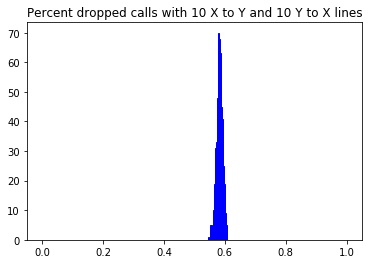

Average call drop percentage: 0.581532860944
Percent call drop percentage below 5%: 0.0


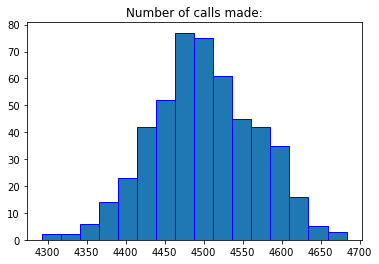

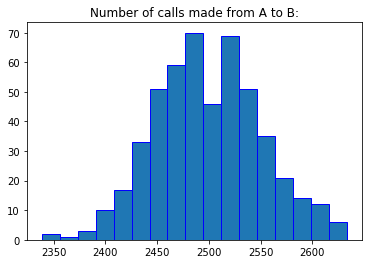

Average calls made from A to B: 2499.234


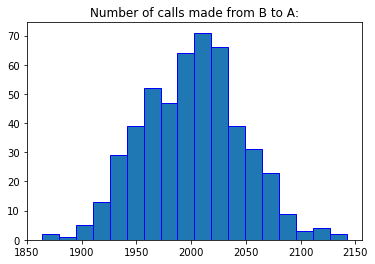

Average calls made from B to A: 2001.302


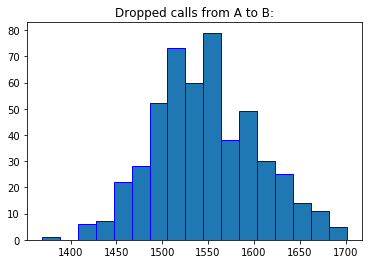

Average number of dropped calls from A to B: 1547.67


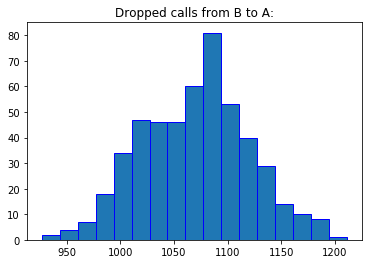

Average number of dropped calls B to A: 1069.914


In [4]:
test_asymmetric(runs=RUN_COUNT, time_limit=TIME_LIMIT, a_to_b=10, b_to_a=10)

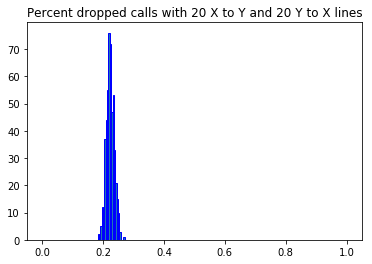

Average call drop percentage: 0.222986439773
Percent call drop percentage below 5%: 0.0


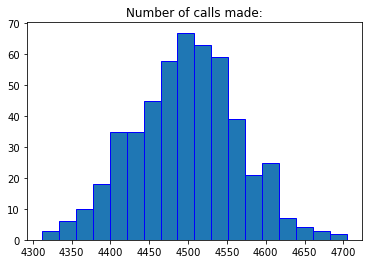

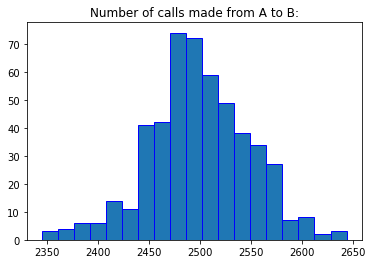

Average calls made from A to B: 2499.112


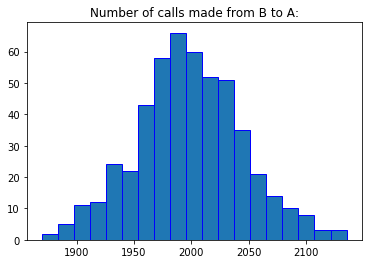

Average calls made from B to A: 1998.174


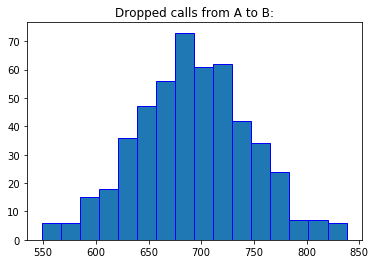

Average number of dropped calls from A to B: 692.61


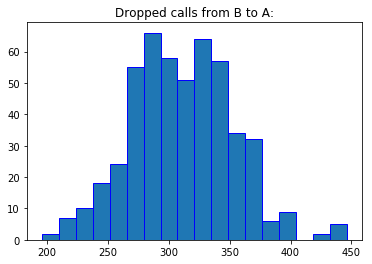

Average number of dropped calls B to A: 310.81


In [5]:
test_asymmetric(runs=RUN_COUNT, time_limit=TIME_LIMIT, a_to_b=20, b_to_a=20)

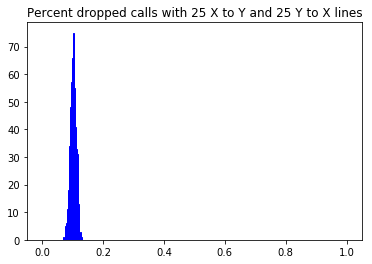

Average call drop percentage: 0.101273326543
Percent call drop percentage below 5%: 0.0


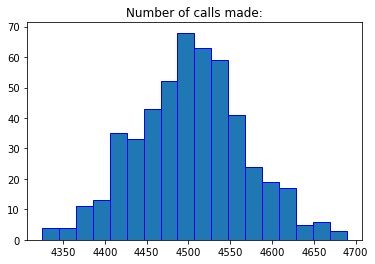

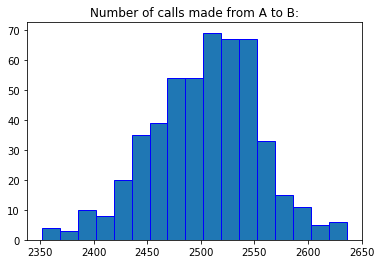

Average calls made from A to B: 2503.698


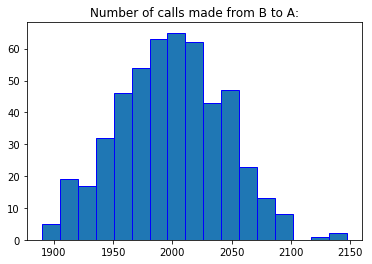

Average calls made from B to A: 1998.568


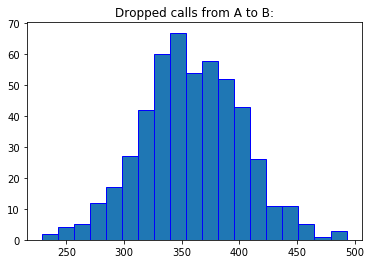

Average number of dropped calls from A to B: 359.09


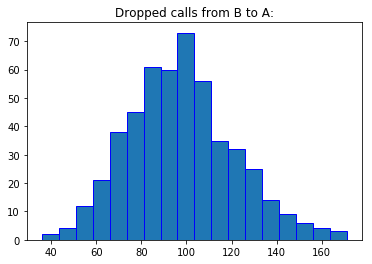

Average number of dropped calls B to A: 97.236


In [6]:
test_asymmetric(runs=RUN_COUNT, time_limit=TIME_LIMIT, a_to_b=25, b_to_a=25)

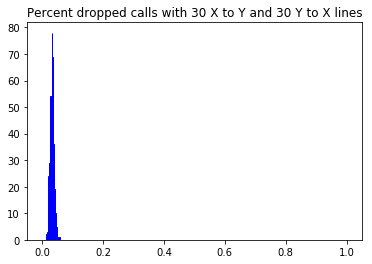

Average call drop percentage: 0.0319603496726
Percent call drop percentage below 5%: 0.994


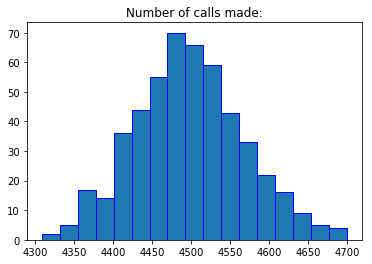

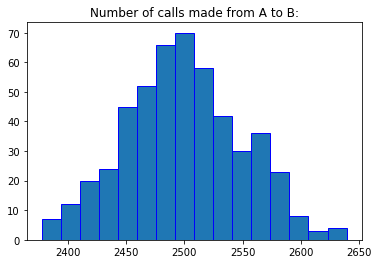

Average calls made from A to B: 2499.158


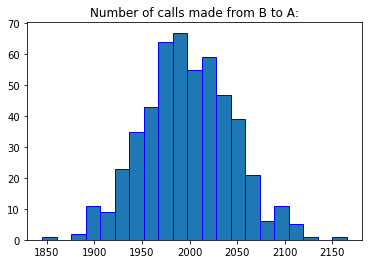

Average calls made from B to A: 1998.206


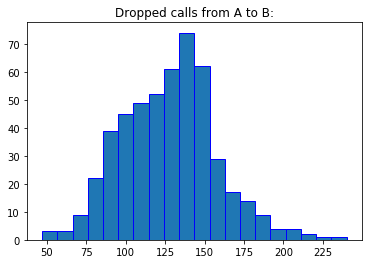

Average number of dropped calls from A to B: 127.504


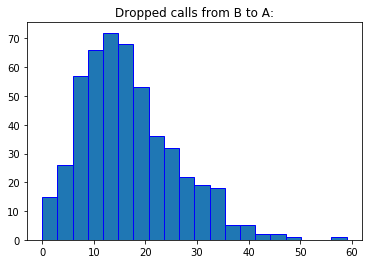

Average number of dropped calls B to A: 16.454


In [7]:
test_asymmetric(runs=RUN_COUNT, time_limit=TIME_LIMIT, a_to_b=30, b_to_a=30)

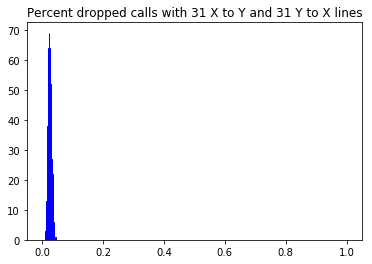

Average call drop percentage: 0.0243572659986
Percent call drop percentage below 5%: 1.0


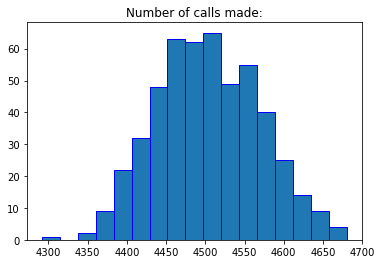

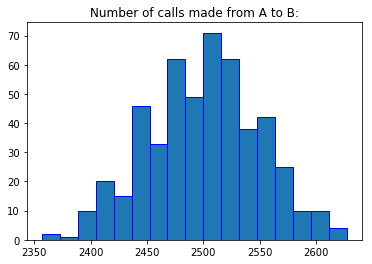

Average calls made from A to B: 2500.314


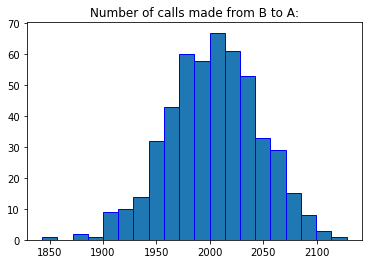

Average calls made from B to A: 2003.162


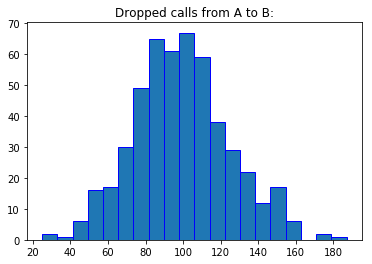

Average number of dropped calls from A to B: 99.158


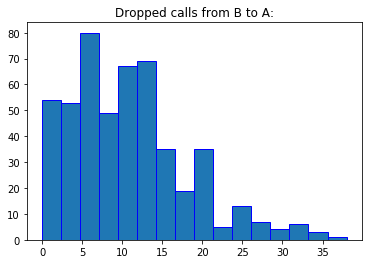

Average number of dropped calls B to A: 10.73


In [8]:
test_asymmetric(runs=RUN_COUNT, time_limit=TIME_LIMIT, a_to_b=31, b_to_a=31)

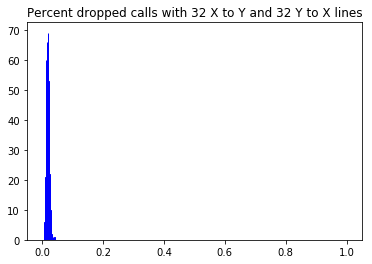

Average call drop percentage: 0.0178544387556
Percent call drop percentage below 5%: 1.0


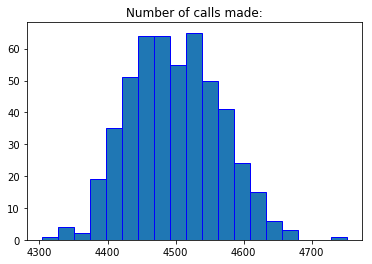

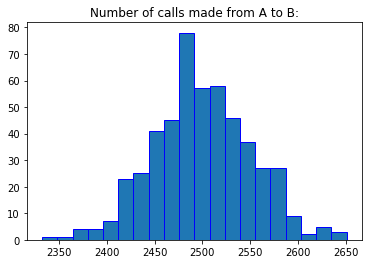

Average calls made from A to B: 2500.084


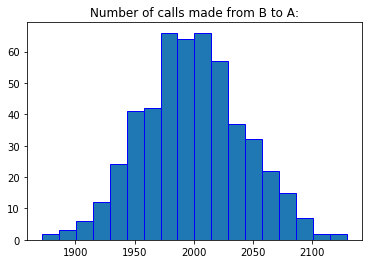

Average calls made from B to A: 1999.17


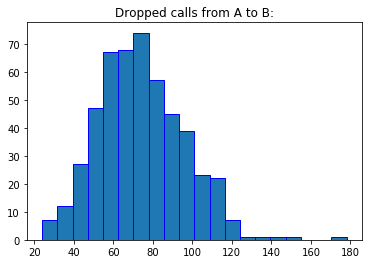

Average number of dropped calls from A to B: 74.078


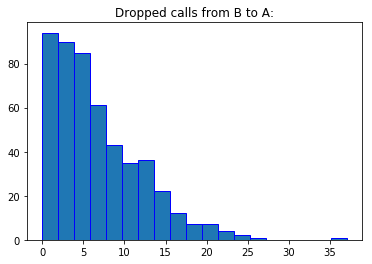

Average number of dropped calls B to A: 6.402


In [9]:
test_asymmetric(runs=RUN_COUNT, time_limit=TIME_LIMIT, a_to_b=32, b_to_a=32)

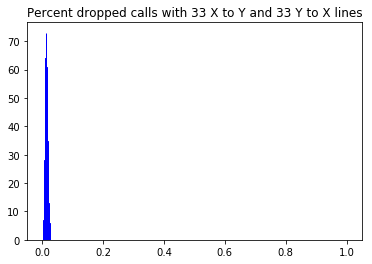

Average call drop percentage: 0.0132526029537
Percent call drop percentage below 5%: 1.0


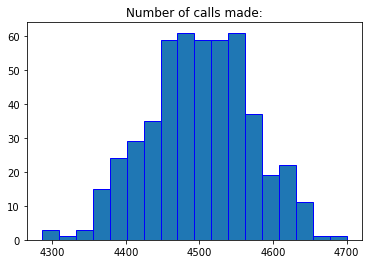

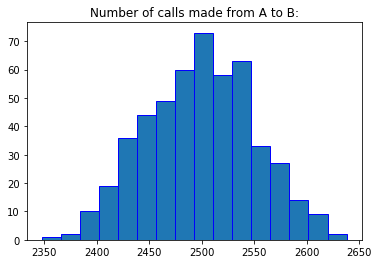

Average calls made from A to B: 2499.426


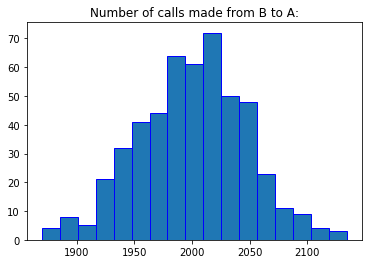

Average calls made from B to A: 1999.656


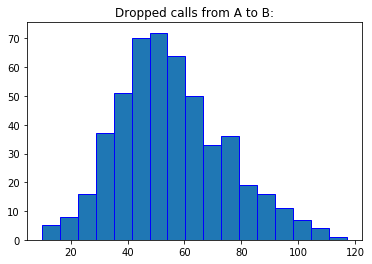

Average number of dropped calls from A to B: 55.378


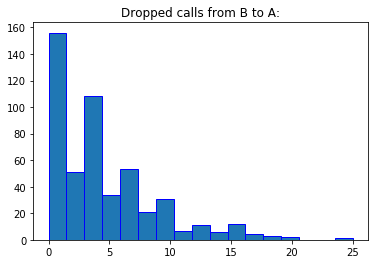

Average number of dropped calls B to A: 4.356


In [10]:
test_asymmetric(runs=RUN_COUNT, time_limit=TIME_LIMIT, a_to_b=33, b_to_a=33)

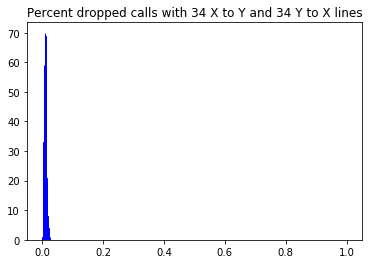

Average call drop percentage: 0.00936157564867
Percent call drop percentage below 5%: 1.0


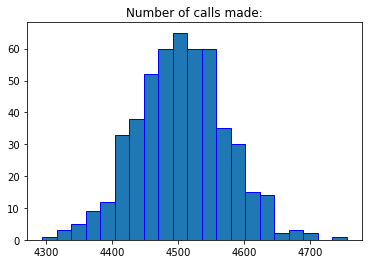

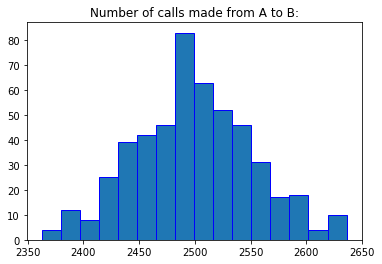

Average calls made from A to B: 2499.524


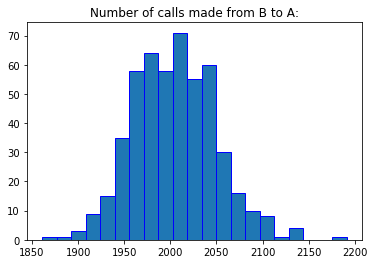

Average calls made from B to A: 2004.382


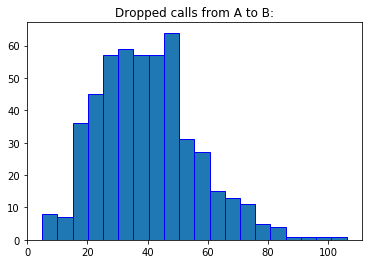

Average number of dropped calls from A to B: 39.902


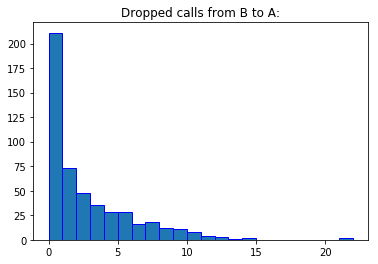

Average number of dropped calls B to A: 2.376


In [11]:
test_asymmetric(runs=RUN_COUNT, time_limit=TIME_LIMIT, a_to_b=34, b_to_a=34)

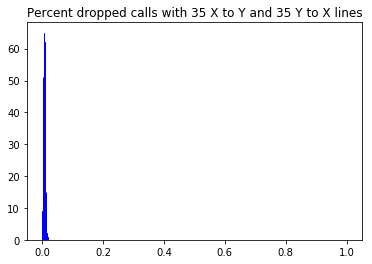

Average call drop percentage: 0.0065497465787
Percent call drop percentage below 5%: 1.0


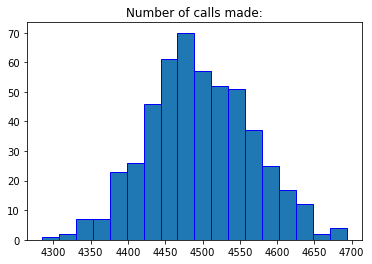

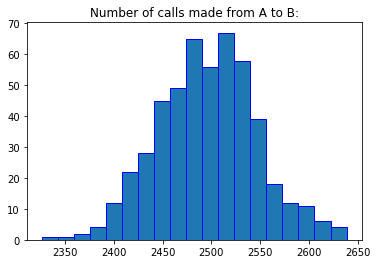

Average calls made from A to B: 2496.208


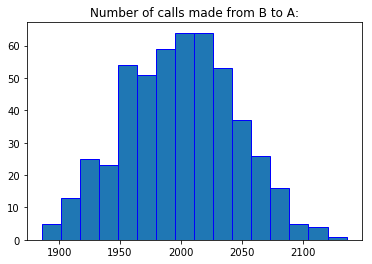

Average calls made from B to A: 1999.184


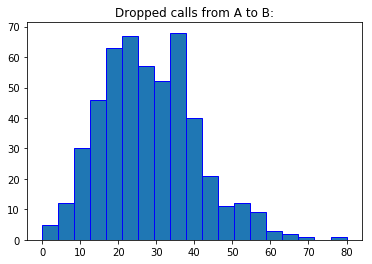

Average number of dropped calls from A to B: 28.31


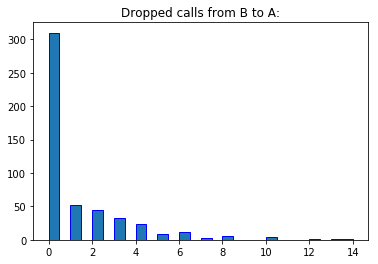

Average number of dropped calls B to A: 1.194


In [12]:
test_asymmetric(runs=RUN_COUNT, time_limit=TIME_LIMIT, a_to_b=35, b_to_a=35)

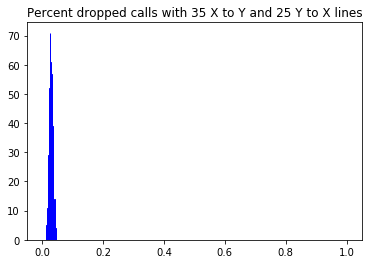

Average call drop percentage: 0.0282347235253
Percent call drop percentage below 5%: 1.0


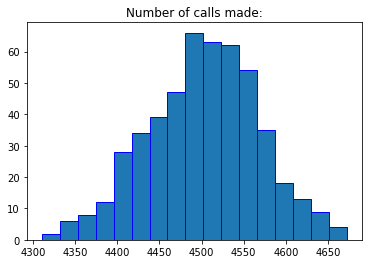

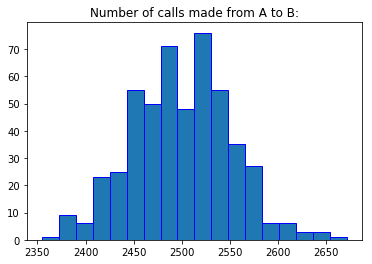

Average calls made from A to B: 2499.056


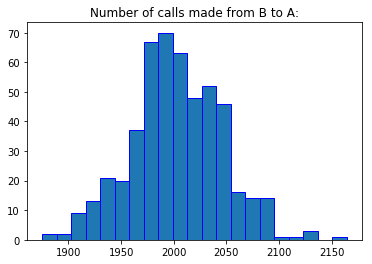

Average calls made from B to A: 2002.634


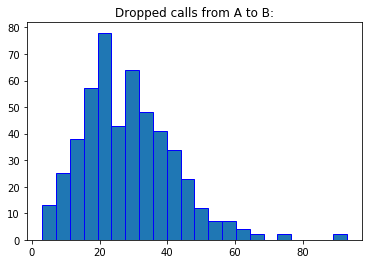

Average number of dropped calls from A to B: 28.386


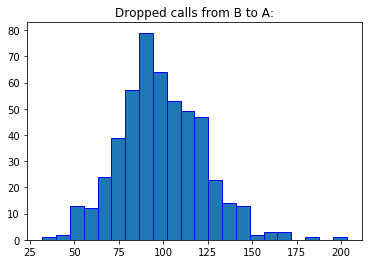

Average number of dropped calls B to A: 98.904


In [13]:
test_asymmetric(runs=RUN_COUNT, time_limit=TIME_LIMIT, a_to_b=35, b_to_a=25)

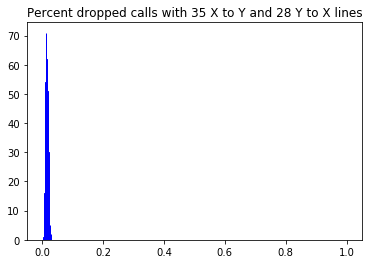

Average call drop percentage: 0.0144549030705
Percent call drop percentage below 5%: 1.0


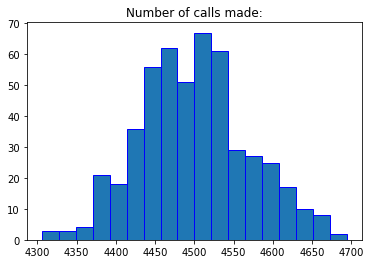

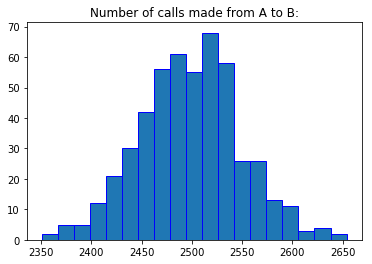

Average calls made from A to B: 2498.294


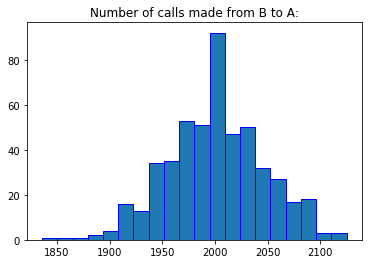

Average calls made from B to A: 2000.902


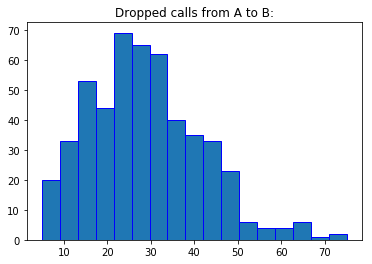

Average number of dropped calls from A to B: 28.65


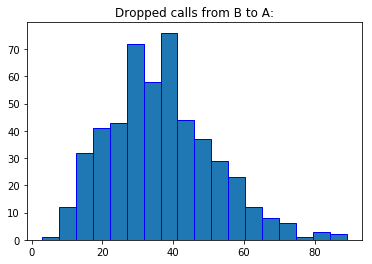

Average number of dropped calls B to A: 36.524


In [14]:
test_asymmetric(runs=RUN_COUNT, time_limit=TIME_LIMIT, a_to_b=35, b_to_a=28)

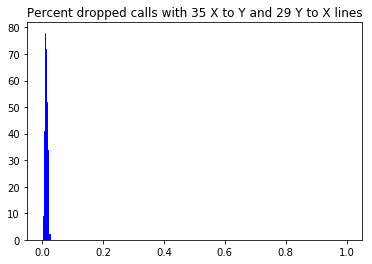

Average call drop percentage: 0.0119478630139
Percent call drop percentage below 5%: 1.0


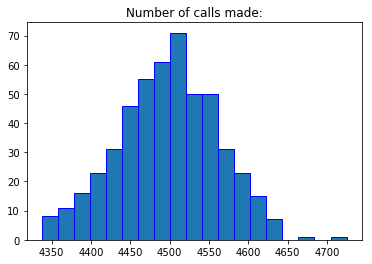

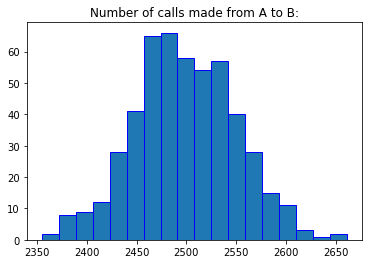

Average calls made from A to B: 2497.76


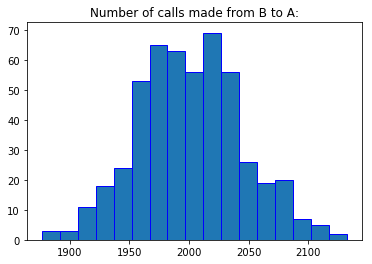

Average calls made from B to A: 2000.26


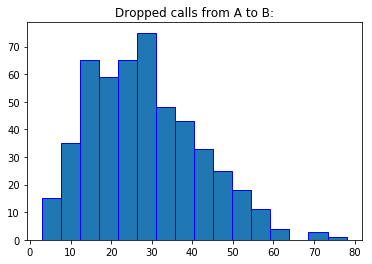

Average number of dropped calls from A to B: 28.47


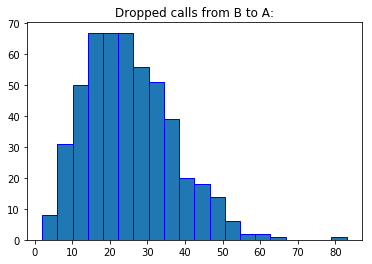

Average number of dropped calls B to A: 25.376


In [15]:
test_asymmetric(runs=RUN_COUNT, time_limit=TIME_LIMIT, a_to_b=35, b_to_a=29)

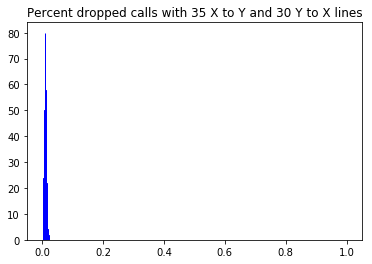

Average call drop percentage: 0.00994207732832
Percent call drop percentage below 5%: 1.0


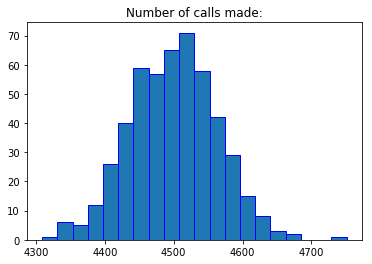

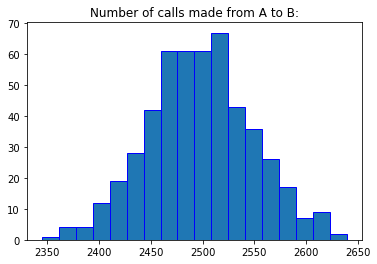

Average calls made from A to B: 2497.016


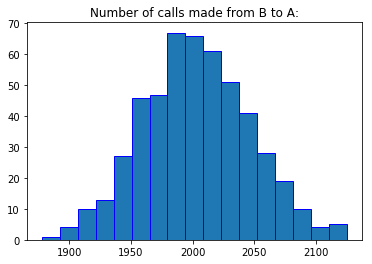

Average calls made from B to A: 2002.978


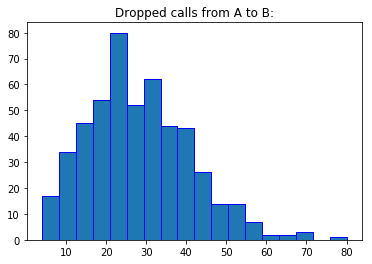

Average number of dropped calls from A to B: 28.132


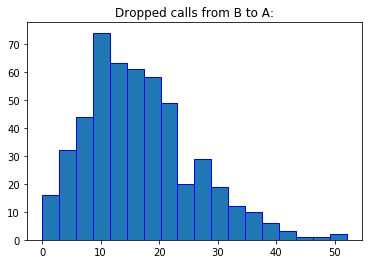

Average number of dropped calls B to A: 16.7


In [16]:
test_asymmetric(runs=RUN_COUNT, time_limit=TIME_LIMIT, a_to_b=35, b_to_a=30)

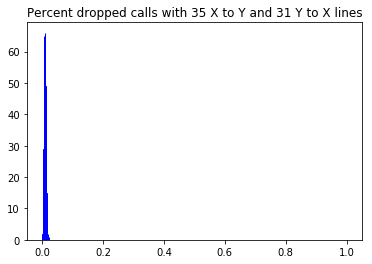

Average call drop percentage: 0.00857667324069
Percent call drop percentage below 5%: 1.0


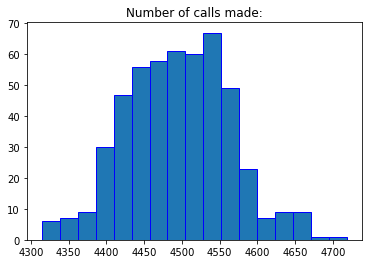

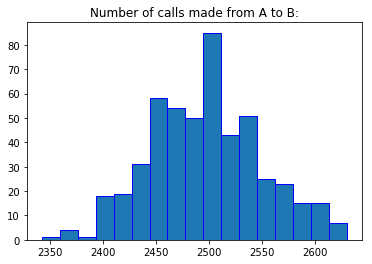

Average calls made from A to B: 2496.774


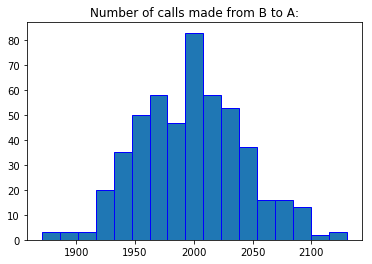

Average calls made from B to A: 1998.056


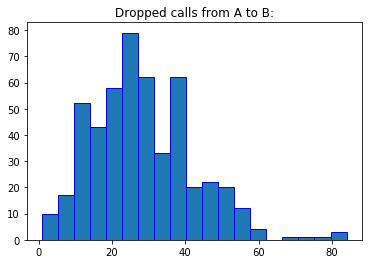

Average number of dropped calls from A to B: 28.358


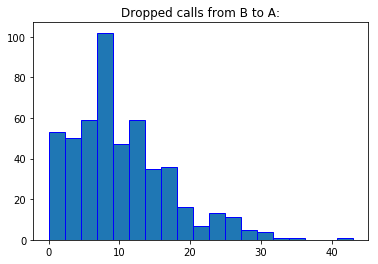

Average number of dropped calls B to A: 10.286


In [17]:
test_asymmetric(runs=RUN_COUNT, time_limit=TIME_LIMIT, a_to_b=35, b_to_a=31)

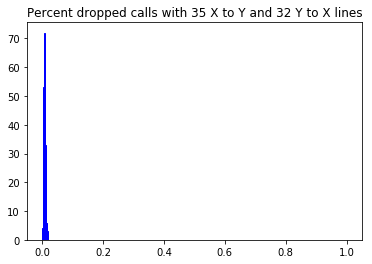

Average call drop percentage: 0.00775123003385
Percent call drop percentage below 5%: 1.0


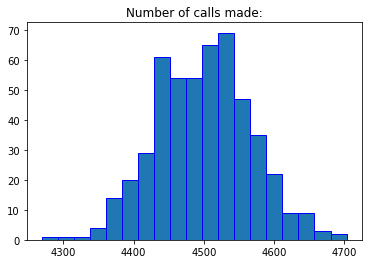

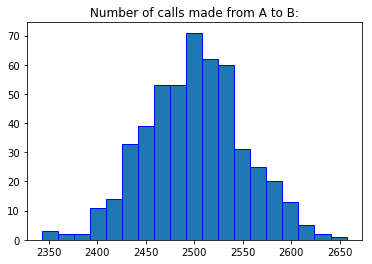

Average calls made from A to B: 2500.606


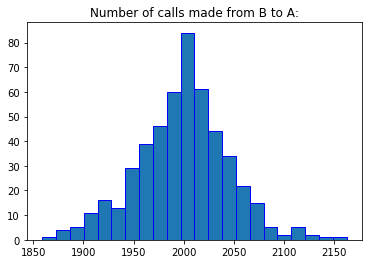

Average calls made from B to A: 1999.472


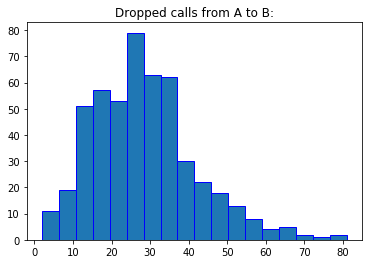

Average number of dropped calls from A to B: 28.428


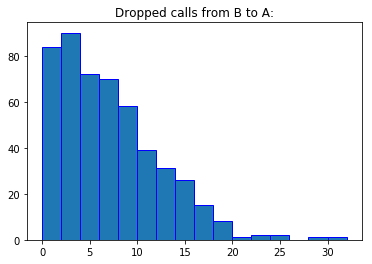

Average number of dropped calls B to A: 6.538


In [18]:
test_asymmetric(runs=RUN_COUNT, time_limit=TIME_LIMIT, a_to_b=35, b_to_a=32)

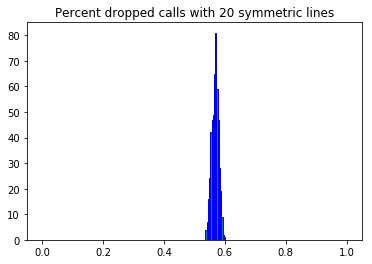

Average call drop percentage: 0.567324808795
Percent call drop percentage below 5%: 0.0


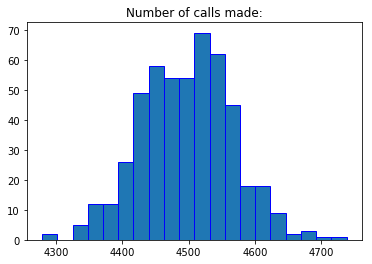

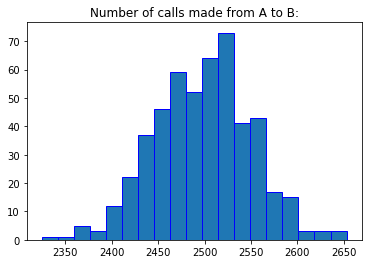

Average calls made from A to B: 2498.244


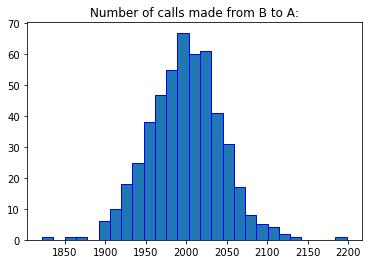

Average calls made from B to A: 1998.454


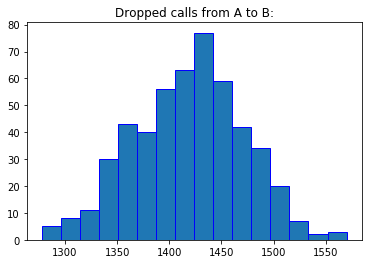

Average number of dropped calls from A to B: 1419.048


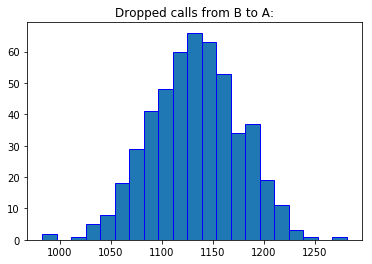

Average number of dropped calls B to A: 1132.49


In [19]:
test_symmetric(runs=RUN_COUNT, time_limit=TIME_LIMIT, total_lines=20)

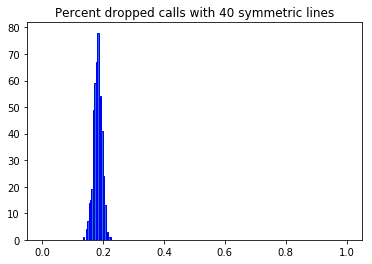

Average call drop percentage: 0.181378327222
Percent call drop percentage below 5%: 0.0


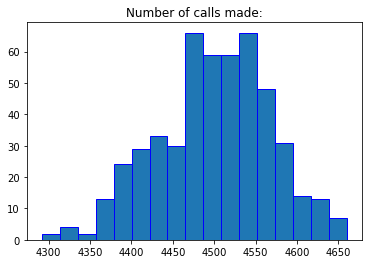

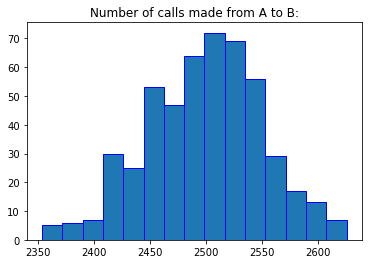

Average calls made from A to B: 2498.772


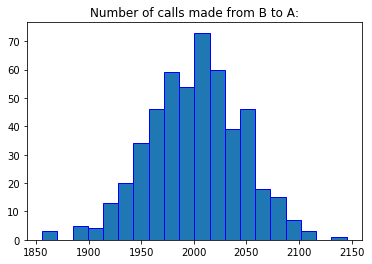

Average calls made from B to A: 2001.012


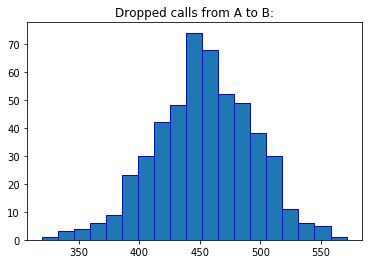

Average number of dropped calls from A to B: 454.034


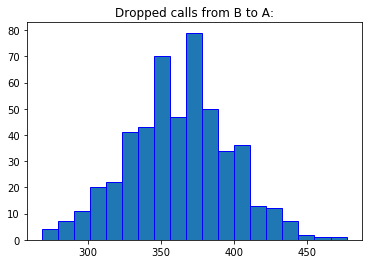

Average number of dropped calls B to A: 362.716


In [20]:
test_symmetric(runs=RUN_COUNT, time_limit=TIME_LIMIT, total_lines=40)

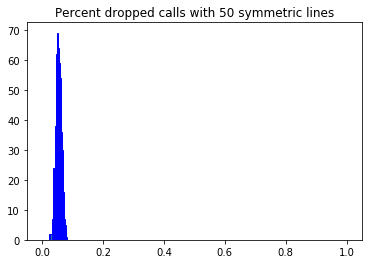

Average call drop percentage: 0.0526057579427
Percent call drop percentage below 5%: 0.396


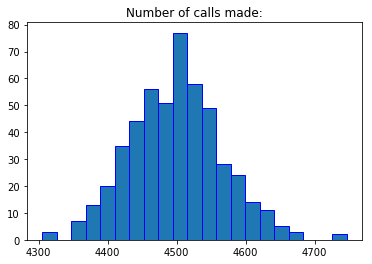

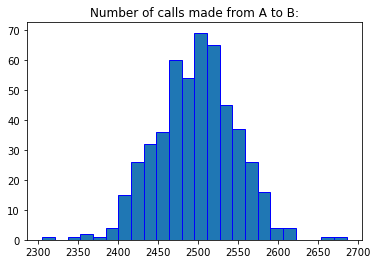

Average calls made from A to B: 2497.708


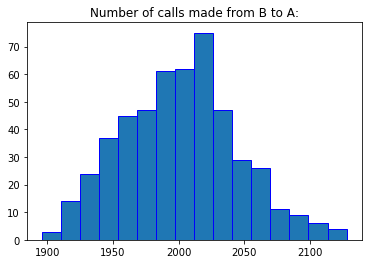

Average calls made from B to A: 2001.056


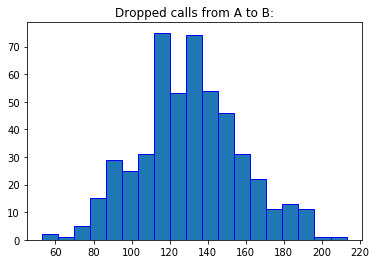

Average number of dropped calls from A to B: 130.898


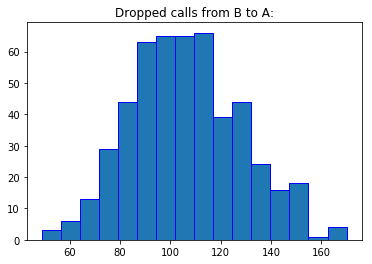

Average number of dropped calls B to A: 106.154


In [21]:
test_symmetric(runs=RUN_COUNT, time_limit=TIME_LIMIT, total_lines=50)

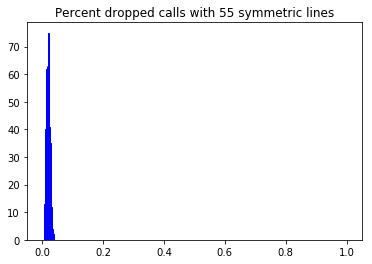

Average call drop percentage: 0.0196634703305
Percent call drop percentage below 5%: 1.0


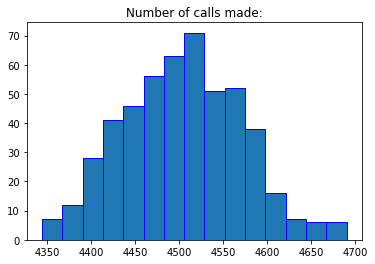

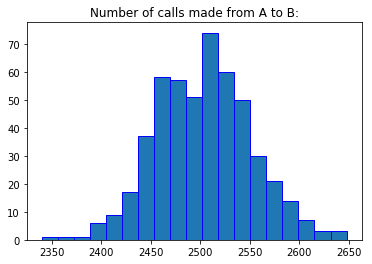

Average calls made from A to B: 2503.29


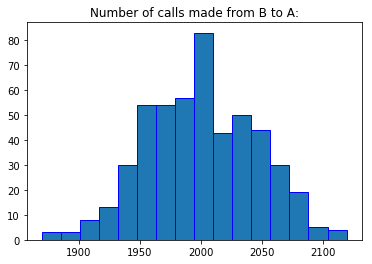

Average calls made from B to A: 2000.418


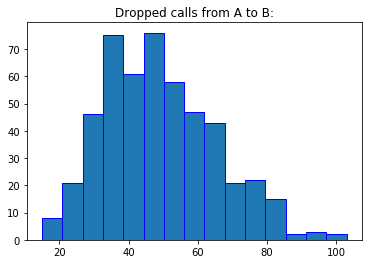

Average number of dropped calls from A to B: 48.954


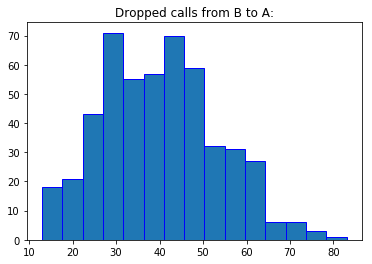

Average number of dropped calls B to A: 39.816


In [22]:
test_symmetric(runs=RUN_COUNT, time_limit=TIME_LIMIT, total_lines=55)

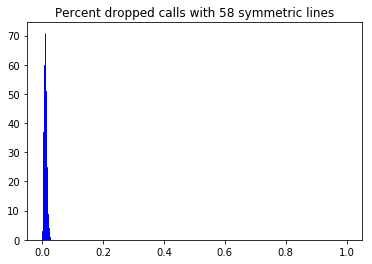

Average call drop percentage: 0.00923420646354
Percent call drop percentage below 5%: 1.0


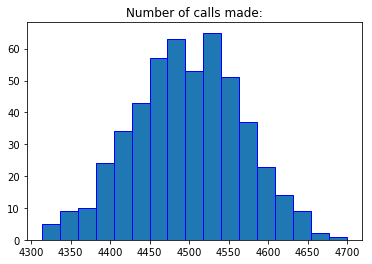

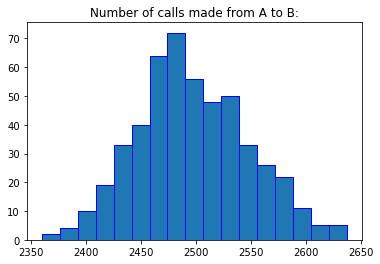

Average calls made from A to B: 2496.768


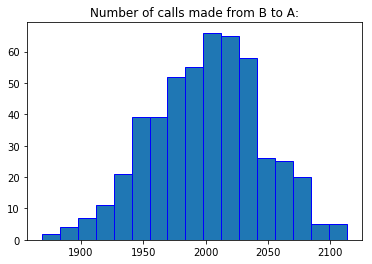

Average calls made from B to A: 2000.252


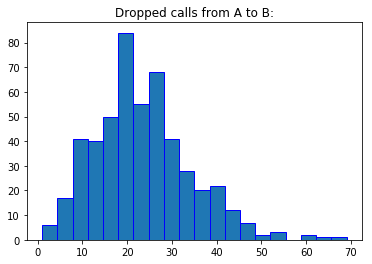

Average number of dropped calls from A to B: 23.302


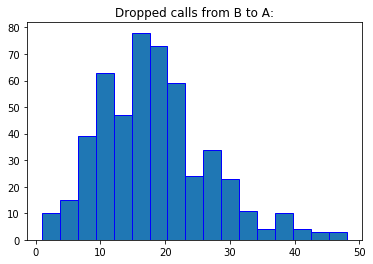

Average number of dropped calls B to A: 18.352


In [23]:
test_symmetric(runs=RUN_COUNT, time_limit=TIME_LIMIT, total_lines=58)

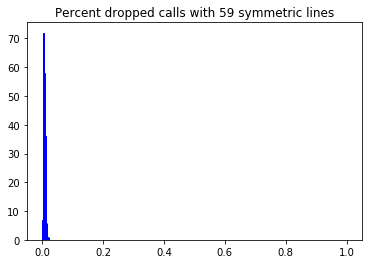

Average call drop percentage: 0.00688867556746
Percent call drop percentage below 5%: 1.0


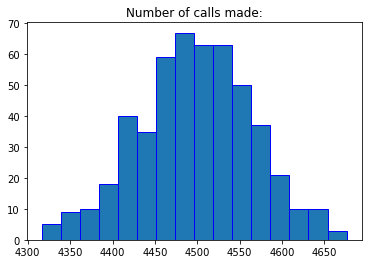

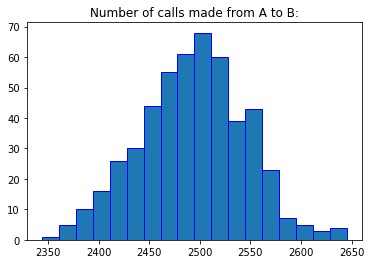

Average calls made from A to B: 2493.388


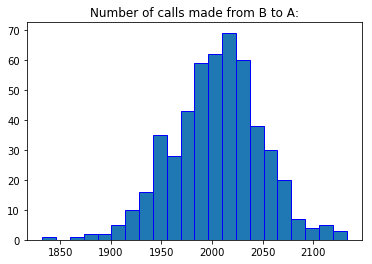

Average calls made from B to A: 2004.848


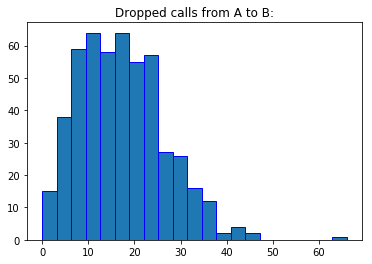

Average number of dropped calls from A to B: 17.196


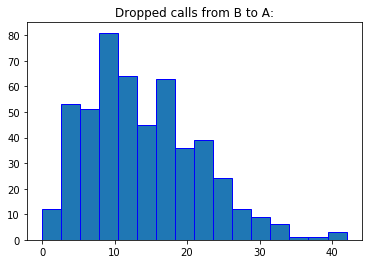

Average number of dropped calls B to A: 13.886


In [24]:
test_symmetric(runs=RUN_COUNT, time_limit=TIME_LIMIT, total_lines=59)

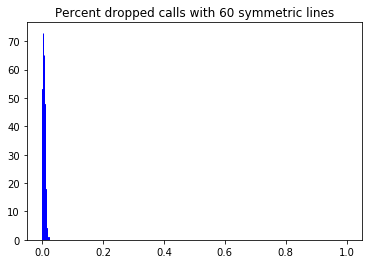

Average call drop percentage: 0.00545800656064
Percent call drop percentage below 5%: 1.0


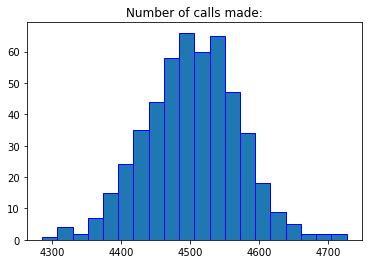

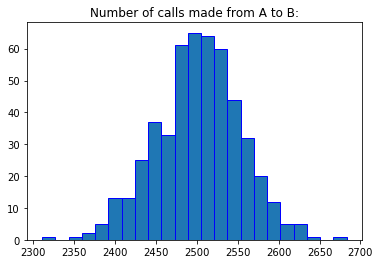

Average calls made from A to B: 2502.35


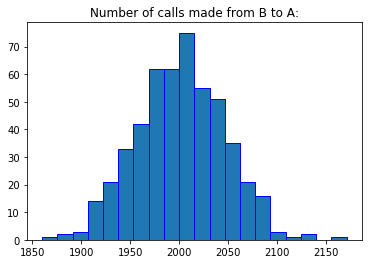

Average calls made from B to A: 2001.356


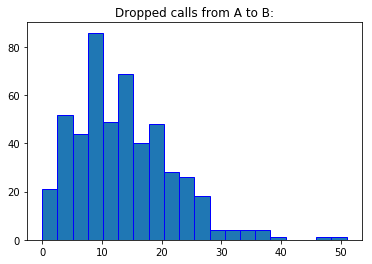

Average number of dropped calls from A to B: 13.576


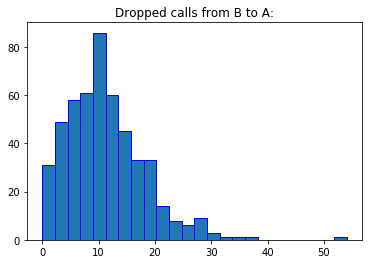

Average number of dropped calls B to A: 11.084


In [25]:
test_symmetric(runs=RUN_COUNT, time_limit=TIME_LIMIT, total_lines=60)

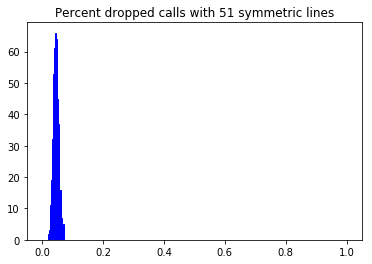

Average call drop percentage: 0.0445972996028
Percent call drop percentage below 5%: 0.744


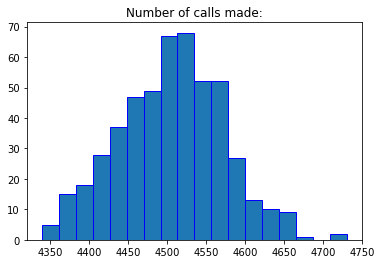

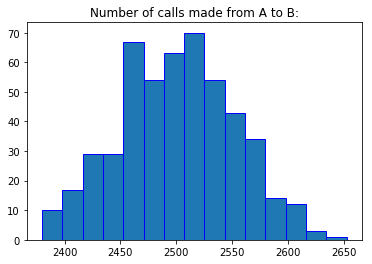

Average calls made from A to B: 2500.626


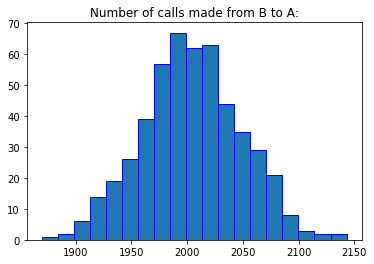

Average calls made from B to A: 2004.724


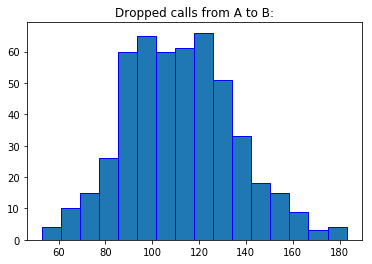

Average number of dropped calls from A to B: 112.028


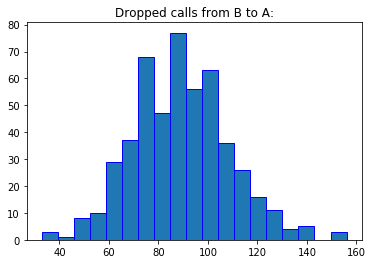

Average number of dropped calls B to A: 89.254


In [26]:
test_symmetric(runs=RUN_COUNT, time_limit=TIME_LIMIT, total_lines=51)

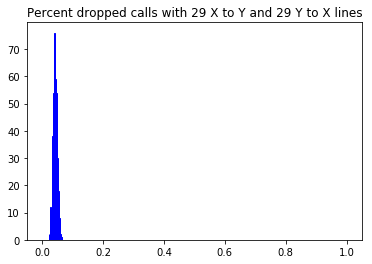

Average call drop percentage: 0.0418595450886
Percent call drop percentage below 5%: 0.866


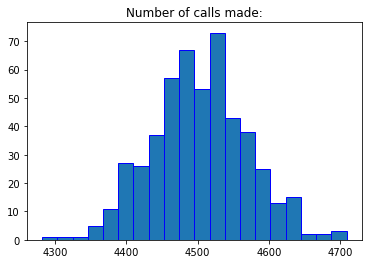

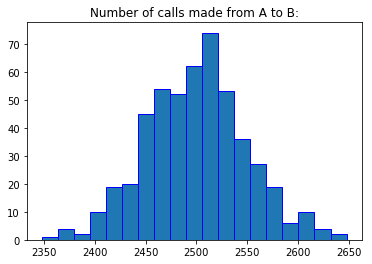

Average calls made from A to B: 2500.188


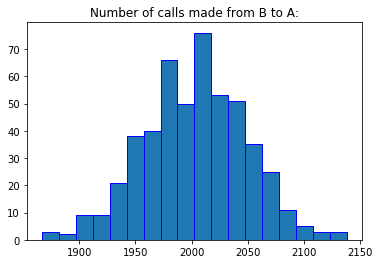

Average calls made from B to A: 2003.204


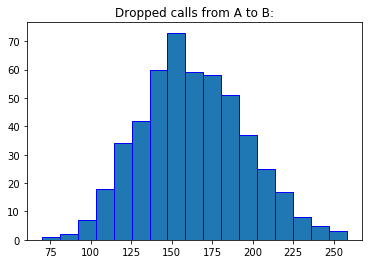

Average number of dropped calls from A to B: 162.786


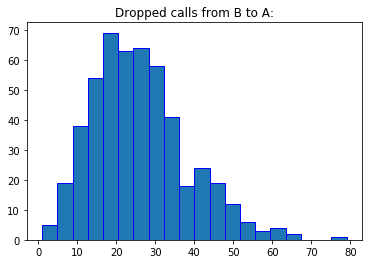

Average number of dropped calls B to A: 25.966


In [27]:
test_asymmetric(runs=RUN_COUNT, time_limit=TIME_LIMIT, a_to_b=29, b_to_a=29)